In [3]:
%load_ext autoreload
%autoreload 2

import random
import numpy as np
import helper_functions as hp
import pandas as pd
import cv2
import matplotlib as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
#from keras import backend as K

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import tensorflow as tf
tf.test.gpu_device_name()
tf.test.is_gpu_available()

True

## Load in planetscope dataset and create a simple CNN with it.

In [5]:
# Load in planetscope data
#K.clear_session()
planetscope_images_tif, planetscope_labels_tif = hp.dataset_reader_planetscope('planetscope_chips_90m_3class_classified_tiles')

reading in 30466 images


In [16]:
np.unique(planetscope_labels_tif, axis=0, return_counts=True)

(array([1, 2, 3], dtype=uint16), array([ 6236,   308, 23922], dtype=int64))

In [17]:
# Shuffle labels and images and create a train test split for planetscope data
train_images, test_images, train_labels, test_labels = train_test_split(planetscope_images_tif, planetscope_labels_tif, test_size=.2, shuffle=True)

## Do oversampling and data augmentation on planetscope data

In [18]:
# Map images and labels using pandas dataframe
df_dict = {"images": [], "labels": []}

for i in range(len(train_images)):
    df_dict["images"].append(train_images[i])
    df_dict["labels"].append(train_labels[i])

df = pd.DataFrame(data=df_dict)

label_1_rows = df.loc[df['labels'] == 1]
label_2_rows = df.loc[df['labels'] == 2]
label_3_rows = df.loc[df['labels'] == 3]

print(len(label_1_rows))
print(len(label_2_rows))
print(len(label_3_rows))

5013
255
19104


In [19]:
# Oversample and data augment images from labels 1 and 2 for planetscope
new_L1_df = hp.augment_label_1(label_1_rows)
print("New label 1 images:", len(new_L1_df))

new_L2_df = hp.augment_label_2(label_2_rows)
print("New label 2 images", len(new_L2_df))

L1_L2 = pd.concat([new_L1_df, new_L2_df], ignore_index=True)
new_df = pd.concat([L1_L2, label_3_rows], ignore_index=True)

New label 1 images: 20052
New label 2 images 20400


In [20]:
# Get new planetscope images and labels from new dataframe
comb_planetscope_images = []
comb_naip_labels = []

for index, row in new_df.iterrows():
    new_image = row["images"]
    new_label = row["labels"]

    comb_planetscope_images.append(new_image)
    comb_naip_labels.append(new_label)

comb_planetscope_images = np.asarray(comb_planetscope_images)
comb_naip_labels = np.asarray(comb_naip_labels)

In [21]:
# Encode planetscope data
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(comb_naip_labels.reshape(-1, 1))
planetscope_new_labels = enc.transform(comb_naip_labels.reshape(-1, 1)).toarray().astype('uint8')

print(comb_naip_labels[0])
print(comb_naip_labels.shape)

1
(59556,)


In [26]:
# Do a train_test_split with oversampled and augmented data for planetscope
train_images, test_images, train_labels, test_labels = train_test_split(comb_planetscope_images, planetscope_new_labels, test_size=.2, shuffle=True)

In [27]:
np.unique(train_labels, axis=0, return_counts=True)

(array([[0, 0, 1],
        [0, 1, 0],
        [1, 0, 0]], dtype=uint8),
 array([15295, 16357, 15992], dtype=int64))

In [28]:
# Create a simple model for the planetscope data 
model = hp.get_simple_model(train_images[0].shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 50)        5050      
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 30, 50)        200       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 50)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 30)        37530     
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 15, 30)        120       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1470)             

In [29]:
# Calculate initial test accuracy for planetscope data.
test_init = hp.get_test_accuracy(model, test_images, test_labels)
train_init = hp.get_train_accuracy(model, train_images, train_labels)

accuracy: 0.317
accuracy: 0.319


In [30]:
# Train model with planetscope data
history = model.fit(train_images, train_labels, epochs=30, validation_data=(test_images, test_labels))

Train on 47644 samples, validate on 11912 samples
Epoch 1/30
47644/47644 [==============================] - 6s 133us/sample - loss: 0.2834 - acc: 0.8908 - val_loss: 0.2838 - val_acc: 0.8733
Epoch 2/30
47644/47644 [==============================] - 6s 127us/sample - loss: 0.2330 - acc: 0.9079 - val_loss: 0.4982 - val_acc: 0.8016
Epoch 3/30
47644/47644 [==============================] - 6s 126us/sample - loss: 0.2011 - acc: 0.9223 - val_loss: 0.2656 - val_acc: 0.8838
Epoch 4/30
47644/47644 [==============================] - 6s 127us/sample - loss: 0.1629 - acc: 0.9389 - val_loss: 0.8842 - val_acc: 0.7329
Epoch 5/30
47644/47644 [==============================] - 6s 127us/sample - loss: 0.1296 - acc: 0.9531 - val_loss: 0.2844 - val_acc: 0.8817
Epoch 6/30
47644/47644 [==============================] - 6s 127us/sample - loss: 0.0999 - acc: 0.9650 - val_loss: 1.2512 - val_acc: 0.7167
Epoch 7/30
47644/47644 [==============================] - 6s 127us/sample - loss: 0.0845 - acc: 0.9708 - val_l

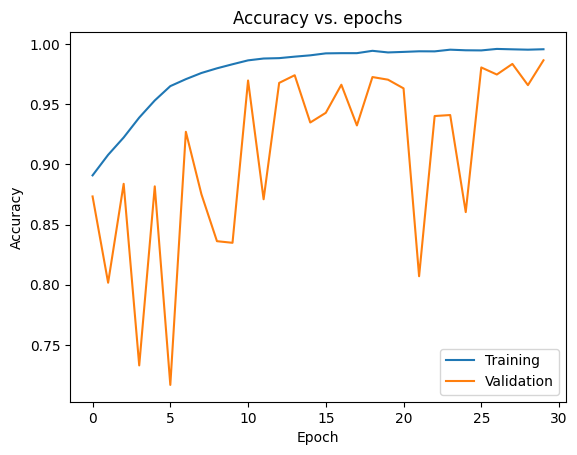

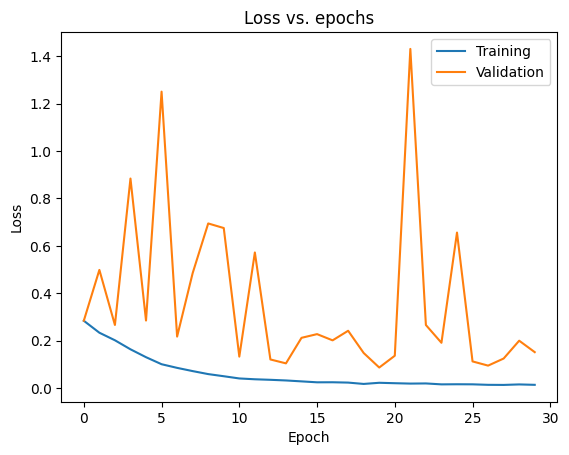

In [31]:
# Plot accuracy for planetscope data
hp.plot_accuracy(history)
hp.plot_loss(history)

In [32]:
# Get accuracy after training the planetscope model once
test_first = hp.get_test_accuracy(model, test_images, test_labels)
train_first = hp.get_train_accuracy(model, train_images, train_labels)

accuracy: 0.986
accuracy: 0.996


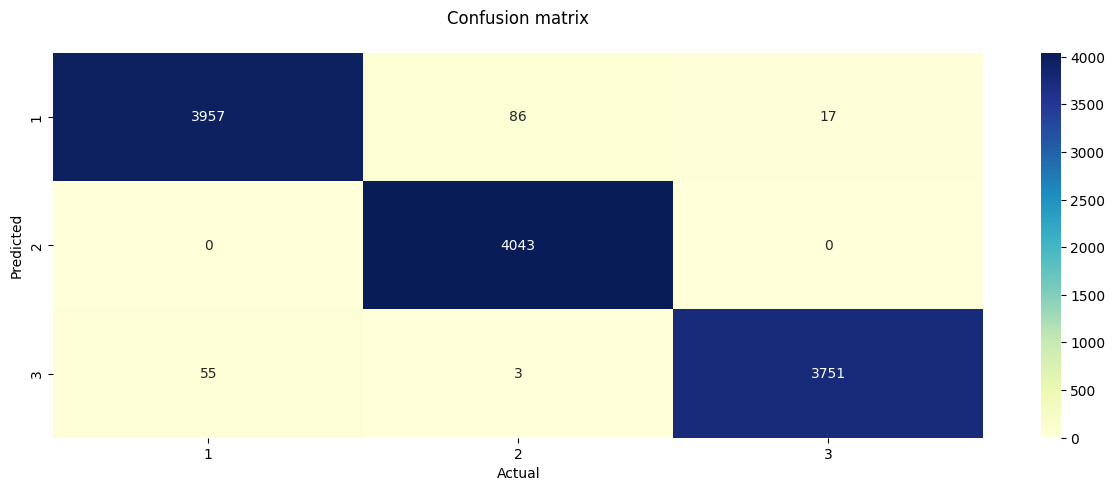

In [35]:
# Plot confusion matrix for planetscope data here
hp.conf_mat(model, test_images, test_labels)

## Load in the naip data and create a simple CNN with it.

In [36]:
naip_images_tif, naip_labels_tif = hp.dataset_reader_naip('naip_2018_chips_90m_3class_classified_tiles')

reading in 30444 images
read in 30441 valid images and labels


In [40]:
np.unique(naip_labels_tif, axis=0, return_counts=True)

(array([1, 2, 3], dtype=uint16), array([ 6204,   319, 23918], dtype=int64))

In [41]:
# Shuffle labels and images and create a train test split for NAIP data
train_images, test_images, train_labels, test_labels = train_test_split(naip_images_tif, naip_labels_tif, test_size=.2, shuffle=True)

## Do oversampling and data augmentation for NAIP data

In [42]:
# Map images and labels using pandas dataframe
df_dict = {"images": [], "labels": []}

for i in range(len(train_images)):
    df_dict["images"].append(train_images[i])
    df_dict["labels"].append(train_labels[i])

df = pd.DataFrame(data=df_dict)

label_1_rows = df.loc[df['labels'] == 1]
label_2_rows = df.loc[df['labels'] == 2]
label_3_rows = df.loc[df['labels'] == 3]

print(len(label_1_rows))
print(len(label_2_rows))
print(len(label_3_rows))

4980
256
19116


In [45]:
# Oversample and data augment images from labels 1 and 2 for naip
new_L1_df = hp.augment_label_1(label_1_rows)
print("New label 1 images:", len(new_L1_df))

new_L2_df = hp.augment_label_2(label_2_rows)
print("New label 2 images", len(new_L2_df))

L1_L2 = pd.concat([new_L1_df, new_L2_df], ignore_index=True)
new_df = pd.concat([L1_L2, label_3_rows], ignore_index=True)

L1_L2 = pd.concat([new_L1_df, new_L2_df], ignore_index=True)
new_df = pd.concat([L1_L2, label_3_rows], ignore_index=True)

New label 1 images: 19920
New label 2 images 20480


In [46]:
# Get new naip images and labels from new dataframe
comb_naip_images = []
comb_naip_labels = []

for index, row in new_df.iterrows():
    new_image = row["images"]
    new_label = row["labels"]

    comb_naip_images.append(new_image)
    comb_naip_labels.append(new_label)

comb_naip_images = np.asarray(comb_naip_images)
comb_naip_labels = np.asarray(comb_naip_labels)

In [47]:
# Encode naip data
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(comb_naip_labels.reshape(-1, 1))
naip_new_labels = enc.transform(comb_naip_labels.reshape(-1, 1)).toarray().astype('uint8')

print(comb_naip_labels[0])
print(comb_naip_labels.shape)

1
(59516,)


In [48]:
# Do a train_test_split with oversampled and augmented data for naip
train_images, test_images, train_labels, test_labels = train_test_split(comb_naip_images, naip_new_labels, test_size=.2, shuffle=True)

In [50]:
np.unique(train_labels, axis=0, return_counts=True)

(array([[0, 0, 1],
        [0, 1, 0],
        [1, 0, 0]], dtype=uint8),
 array([15286, 16401, 15925], dtype=int64))

In [51]:
# Create a simple model for the NAIP data 
model = hp.get_simple_model(train_images[0].shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 90, 90, 50)        5050      
_________________________________________________________________
batch_normalization_8 (Batch (None, 90, 90, 50)        200       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 50)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 30)        37530     
_________________________________________________________________
batch_normalization_9 (Batch (None, 45, 45, 30)        120       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 30)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 14520)            

In [52]:
# Calculate initial test accuracy for NAIP data
test_init = hp.get_test_accuracy(model, test_images, test_labels)
train_init = hp.get_train_accuracy(model, train_images, train_labels)

accuracy: 0.336
accuracy: 0.334


In [53]:
# Train model with NAIP data
history = model.fit(train_images, train_labels, epochs=30, validation_data=(test_images, test_labels))

Train on 47612 samples, validate on 11904 samples
Epoch 1/30
47612/47612 [==============================] - 19s 392us/sample - loss: 0.2246 - acc: 0.9151 - val_loss: 0.1432 - val_acc: 0.9469
Epoch 2/30
47612/47612 [==============================] - 18s 385us/sample - loss: 0.0875 - acc: 0.9701 - val_loss: 0.0962 - val_acc: 0.9678
Epoch 3/30
47612/47612 [==============================] - 18s 384us/sample - loss: 0.0378 - acc: 0.9875 - val_loss: 0.1190 - val_acc: 0.9636
Epoch 4/30
47612/47612 [==============================] - 18s 385us/sample - loss: 0.0263 - acc: 0.9915 - val_loss: 0.2433 - val_acc: 0.9214
Epoch 5/30
47612/47612 [==============================] - 18s 385us/sample - loss: 0.0212 - acc: 0.9935 - val_loss: 0.0708 - val_acc: 0.9774
Epoch 6/30
47612/47612 [==============================] - 18s 385us/sample - loss: 0.0159 - acc: 0.9949 - val_loss: 0.0751 - val_acc: 0.9817
Epoch 7/30
47612/47612 [==============================] - 18s 384us/sample - loss: 0.0116 - acc: 0.9961 

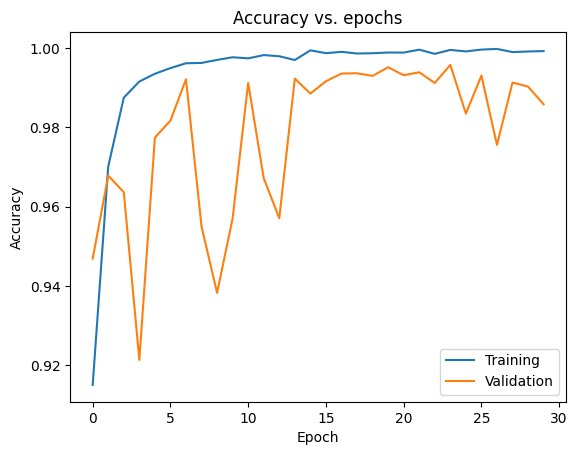

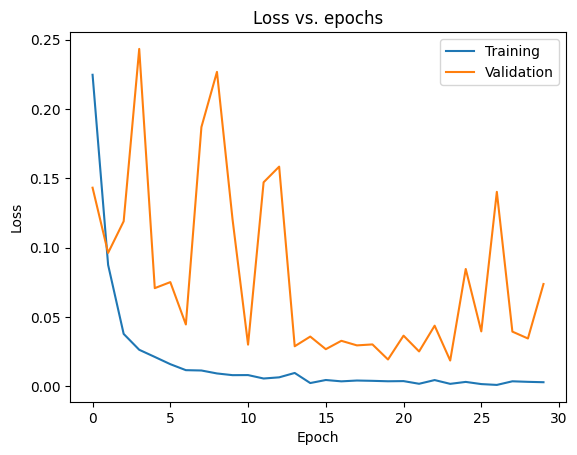

In [54]:
# Plot accuracy for NAIP data
hp.plot_accuracy(history)
hp.plot_loss(history)

In [55]:
# Get accuracy after training the NAIP model once
test_first = hp.get_test_accuracy(model, test_images, test_labels)
train_first = hp.get_train_accuracy(model, train_images, train_labels)

accuracy: 0.986
accuracy: 0.999


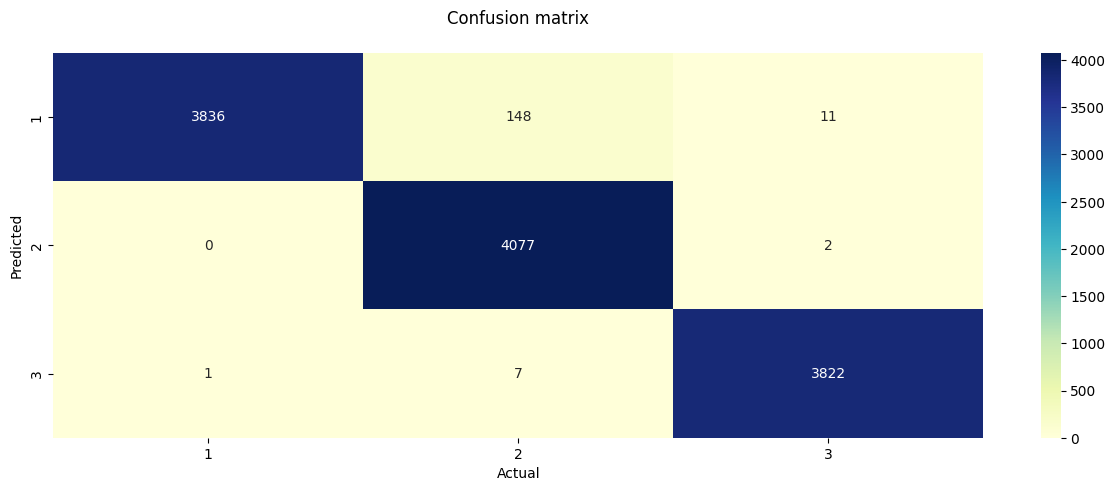

In [56]:
# Plot confusion matrix for naip data here
hp.conf_mat(model, test_images, test_labels)

## Make TL model for NAIP Data Here

In [67]:
img = train_images[0]
img = img[:,:,:3]
print(img.shape)
tl_model = hp.get_TL_model(img.shape)
tl_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_13 (Dense)             (None, 64)                131136    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                650       
Total params: 23,719,498
Trainable params: 131,786
Non-trainable params: 23,587,712
_________________________________________________________________


In [68]:
# Calculate initial test accuracy for NAIP data with tl_model
test_init = hp.get_test_accuracy(tl_model, test_images, test_labels)
train_init = hp.get_train_accuracy(tl_model, train_images, train_labels)

ValueError: Error when checking input: expected resnet50_input to have shape (90, 90, 3) but got array with shape (90, 90, 4)